# Effective area to muon tracks

In [1]:
import numpy as np
import h5py
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import RectBivariateSpline

import stan_utility
from aeff_calculator.aeff_calculator import effective_area_tracks

In [2]:
random_seed = 19920715

In [3]:
aeff = effective_area_tracks()

3.5154355304564127

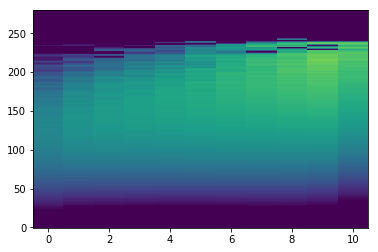

In [4]:
plt.imshow(aeff.log10_aeff_smooth, aspect='auto', origin='lower', vmin=-2, vmax=5)
np.max(aeff.log10_aeff_smooth)

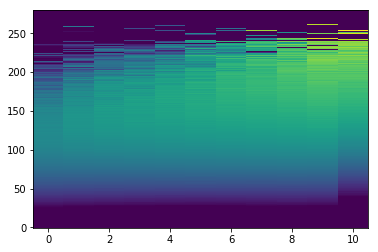

In [5]:
plt.imshow(np.log10(aeff.aeff_vals), aspect='auto', origin='lower', vmin=-2, vmax=5)

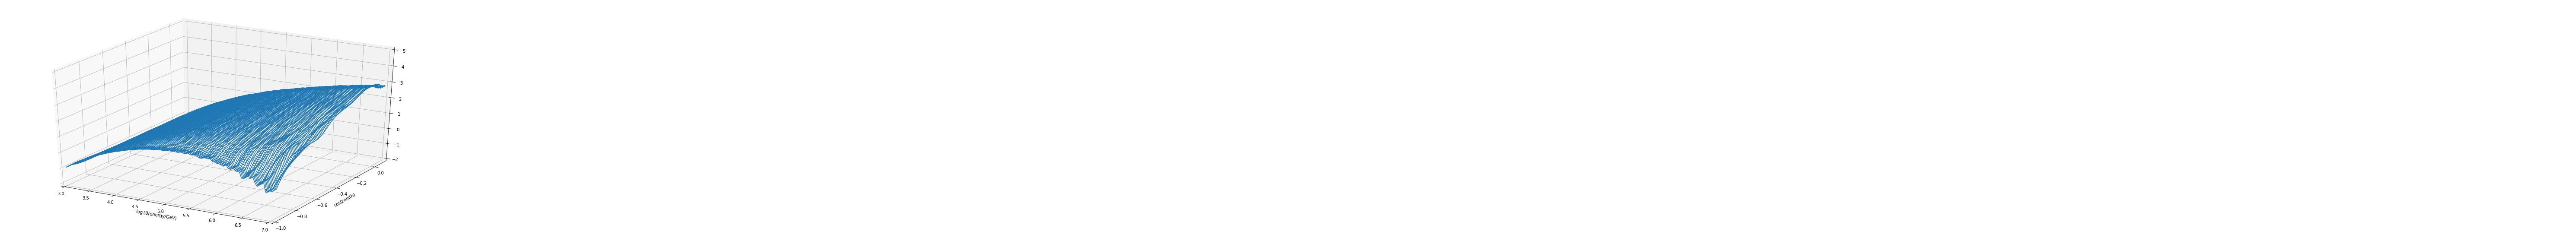

In [6]:
x = np.linspace(3, 7, 500)
y = np.linspace(-1, 0.1, 500)
xx, yy = np.meshgrid(x, y)
xx = xx.T
yy = yy.T
z = aeff.eval(x, y)

fig = plt.figure(figsize=(18, 10))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_wireframe(xx, yy, z, rstride=5, cstride=5)

ax.set_xlabel('log10(energy/GeV)')
ax.set_ylabel('cos(zenith)')
ax.set_xlim([3.0, 7.0])
ax.set_ylim([-1.0, 0.1])
ax.set_zlim([-2, 5]);

In [7]:
p = 3
xknots, yknots = aeff.spline.get_knots()
xknots = np.unique(xknots)
yknots = np.unique(yknots)

c = aeff.spline.get_coeffs()
Nx = len(xknots)+p-1
Ny = len(yknots)+p-1
c = c.reshape(Nx, Ny)

aeff_max = 10**aeff.log10_aeff_max

## Test Stan implemetation

In [8]:
sim = stan_utility.compile_model(filename = 'stan/test_aeff_tracks_cosz.stan', 
                                 model_name = 'aeff_test_cosz', 
                                 include_paths = 'stan/')

Using cached StanModel


In [9]:
sim_input = {}
sim_input['N'] = 2000
sim_input['log10E'] = 6.9
sim_input['aeff_max'] = aeff_max

# Spline
sim_input['p'] = p
sim_input['Lknots_x'] = len(xknots)
sim_input['Lknots_y'] = len(yknots)
sim_input['xknots'] = xknots
sim_input['yknots'] = yknots
sim_input['c'] = c

In [10]:
# Simulate
simulation = sim.sampling(data=sim_input, iter=1, chains=1, 
                          algorithm="Fixed_param", seed=random_seed)

In [11]:
from fancy.interfaces.stan import Direction
from fancy.plotting import AllSkyMap

# Extract output
event = simulation.extract(['direction'])['direction'][0]
pdet = simulation.extract(['pdet'])['pdet'][0]
zenith = simulation.extract(['zenith'])['zenith'][0]
event = Direction(event)
ra = event.d.icrs.ra.rad
dec = event.d.icrs.dec.rad

/Users/fran/.virtualenvs/bayes/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/fran/.virtualenvs/bayes/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


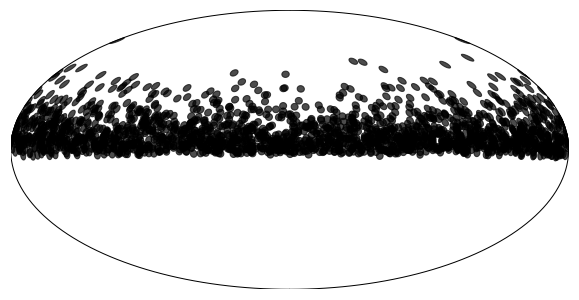

In [12]:
from matplotlib.colors import LinearSegmentedColormap

# Skymap
fig, ax = plt.subplots()
fig.set_size_inches((10, 8))
skymap = AllSkyMap(projection = 'hammer', lon_0=0, lat_0=0);
for r, d in zip(ra, dec):
    skymap.tissot(np.rad2deg(r), np.rad2deg(d), 2, 30, color='k', alpha=0.7)

(0, 1)

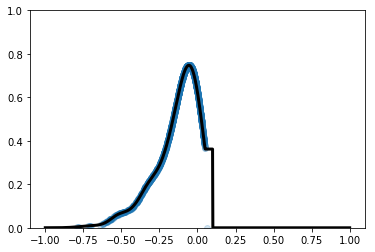

In [13]:
# Compare with original aeff.spline
log10E = sim_input['log10E']
cosz = np.linspace(-1, 1, 1000)
pdet_true = [10**aeff.eval(log10E, _)[0][0] / aeff_max for _ in cosz]

fig, ax = plt.subplots()
ax.plot(cosz, pdet_true, color='k', lw=3)
ax.scatter(np.cos(zenith), pdet, alpha=0.2)
ax.set_ylim(0, 1)

### Test energy 

In [14]:
# Compile Stan model
sim = stan_utility.compile_model(filename = 'stan/test_aeff_tracks_E.stan', 
                                 model_name = 'aeff_test_E', include_paths = 'stan/')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL aeff_test_E_b1e8bac52e9efc739dbc20611f7706e7 NOW.


In [15]:
sim_input = {}
sim_input['N'] = 2000
sim_input['cosz'] = -0.975 
sim_input['aeff_max'] = aeff_max

# Spline
sim_input['p'] = p
sim_input['Lknots_x'] = len(xknots)
sim_input['Lknots_y'] = len(yknots)
sim_input['xknots'] = xknots
sim_input['yknots'] = yknots
sim_input['c'] = c

In [16]:
# Simulate
simulation = sim.sampling(data=sim_input, iter=1, chains=1, 
                          algorithm="Fixed_param", seed=random_seed)

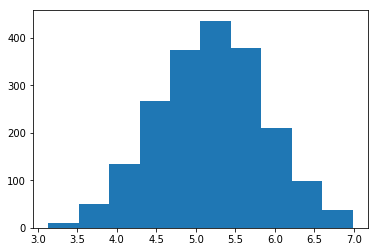

In [17]:
log10E = simulation.extract(['log10E'])['log10E'][0]
pdet = simulation.extract(['pdet'])['pdet'][0]

fig, ax = plt.subplots()
ax.hist(log10E);

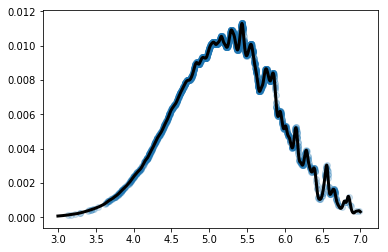

In [18]:
# compare
log10E_true = np.linspace(3.0, 7.0, 1000)
cosz = sim_input['cosz']
pdet_true = [10**aeff.eval(_, cosz)[0][0] / aeff_max for _ in log10E_true]

fig, ax = plt.subplots()
ax.plot(log10E_true, pdet_true, color='k', lw=3)
ax.scatter(log10E, pdet, alpha=0.2)

In [ ]:
yknots

In [ ]:
xknots